SETUP:
1. Download input_images from our drive folder and upload them to colab's runtime files

In [ ]:
import torch
import os
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.optim import SGD
from torchvision import models
import copy
import matplotlib.cm as mpl_color_map
from matplotlib.colors import ListedColormap
import torch.nn as nn


In [ ]:
#Pretrained Model(AlexNet or vgg16)
#Replace the model as models.vgg16(pretrained=True) to change the model
#Replace model_name with vgg16 when vgg16 model is used. 
model_type = models.alexnet(pretrained=True)
model_name = "alexnet"

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
if model_name == "alexnet":
  target_layers  = [9, 16, 23, 30]
else:
  target_layers = [2, 5, 8, 11]

In [ ]:
# setup (visualization library only supports CPU)
device = torch.device('cpu')

In [ ]:
# CNN Visualizer code: (https://github.com/utkuozbulak/pytorch-cnn-visualizations)


In [ ]:
# misc_functions.py

"""
Created on Thu Oct 21 11:09:09 2017
@author: Utku Ozbulak - github.com/utkuozbulak
"""


def convert_to_grayscale(im_as_arr):
    """
        Converts 3d image to grayscale
    Args:
        im_as_arr (numpy arr): RGB image with shape (D,W,H)
    returns:
        grayscale_im (numpy_arr): Grayscale image with shape (1,W,D)
    """
    grayscale_im = np.sum(np.abs(im_as_arr), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = (np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1))
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im


def save_gradient_images(gradient, file_name):
    """
        Exports the original gradient image
    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
        file_name (str): File name to be exported
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    # Save image
    path_to_file = os.path.join('../results', file_name + '.png')
    print("path_to_file = ", path_to_file)
    
    save_image(gradient, path_to_file)


def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Heatmap.png')
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = os.path.join('../results', file_name+'_Cam_On_Image.png')
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = os.path.join('../results', file_name+'_Cam_Grayscale.png')
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image


def apply_heatmap(R, sx, sy):
    """
        Heatmap code stolen from https://git.tu-berlin.de/gmontavon/lrp-tutorial
        This is (so far) only used for LRP
    """
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:, 0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    plt.figure(figsize=(sx, sy))
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.axis('off')
    heatmap = plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='nearest')
    return heatmap
    # plt.show()


def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr


def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)


def preprocess_image(pil_im, resize_im=True):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    # Mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((224, 224), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var


def recreate_image(im_as_var):
    """
        Recreates images from a torch variable, sort of reverse preprocessing
    Args:
        im_as_var (torch variable): Image to recreate
    returns:
        recreated_im (numpy arr): Recreated image in array
    """
    reverse_mean = [-0.485, -0.456, -0.406]
    reverse_std = [1/0.229, 1/0.224, 1/0.225]
    recreated_im = copy.copy(im_as_var.data.numpy()[0])
    for c in range(3):
        recreated_im[c] /= reverse_std[c]
        recreated_im[c] -= reverse_mean[c]
    recreated_im[recreated_im > 1] = 1
    recreated_im[recreated_im < 0] = 0
    recreated_im = np.round(recreated_im * 255)

    recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
    return recreated_im


def get_positive_negative_saliency(gradient):
    """
        Generates positive and negative saliency maps based on the gradient
    Args:
        gradient (numpy arr): Gradient of the operation to visualize
    returns:
        pos_saliency ( )
    """
    pos_saliency = (np.maximum(0, gradient) / gradient.max())
    neg_saliency = (np.maximum(0, -gradient) / -gradient.min())
    return pos_saliency, neg_saliency


def get_example_params(example_index):
    """
        Gets used variables for almost all visualizations, like the image, model etc.
    Args:
        example_index (int): Image id to use from examples
    returns:
        original_image (numpy arr): Original image read from the file
        prep_img (numpy_arr): Processed image
        target_class (int): Target class for the image
        file_name_to_export (string): File name to export the visualizations
        pretrained_model(Pytorch model): Model to use for the operations
    """
    # Pick one of the examples
    example_list = (('input_images/hen.png', 8),
                    ('input_images/hen_kingsnake_10iters_'+model_name+'.png', 56),
                    ('input_images/hen_kingsnake_2iters_'+model_name+'.png', 56),
                    ('input_images/hen_kingsnake_4iters_'+model_name+'.png', 56),
                    ('input_images/hen_kingsnake_7iters_'+model_name+'.png', 56))
    img_path = example_list[example_index][0]
    target_class = example_list[example_index][1]
    file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
    # Read image
    original_image = Image.open(img_path).convert('RGB')
    # Process image
    prep_img = preprocess_image(original_image)
    # Define model
    pretrained_model = model_type
    return (original_image,
            prep_img,
            target_class,
            file_name_to_export,
            pretrained_model)

In [ ]:
#@title create class specific adversarial image
# Create adversarial image


class ClassSpecificImageGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent
    """
    def __init__(self, model, starting_image, target_class):
        self.mean = [-0.485, -0.456, -0.406]
        self.std = [1/0.229, 1/0.224, 1/0.225]
        self.model = model
        self.model.eval()
        self.target_class = target_class
        # Generate a random image
        self.created_image = recreate_image(starting_image)
        # Create the folder to export images if not exists
        if not os.path.exists('../generated/class_'+str(self.target_class)):
            os.makedirs('../generated/class_'+str(self.target_class))

    def generate(self, iterations=150):
        """Generates class specific image
        Keyword Arguments:
            iterations {int} -- Total iterations for gradient ascent (default: {150})
        Returns:
            np.ndarray -- Final maximally activated class image
        """
        initial_learning_rate = 6
        for i in range(1, iterations):
            # Process image and return variable
            self.processed_image = preprocess_image(self.created_image, False)

            # Define optimizer for the image
            optimizer = SGD([self.processed_image], lr=initial_learning_rate)
            # Forward
            output = self.model(self.processed_image)
            # Target specific class
            class_loss = -output[0, self.target_class]

            if i % 10 == 0 or i == iterations-1:
                print('Iteration:', str(i), 'Loss',
                      "{0:.2f}".format(class_loss.data.numpy()))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(self.processed_image)
            # if i % 10 == 0 or i == iterations-1:
            #     # Save image
            #     im_path = '../generated/class_'+str(self.target_class)+'/c_'+str(self.target_class)+'_'+'iter_'+str(i)+'.png'
            #     save_image(self.created_image, im_path)

        return self.processed_image

In [ ]:
target_example = 0 # Hen
(ostrich_image, ostrich_tensor, ostrich_class, file_name_to_export, pretrained_model) = get_example_params(target_example)


In [ ]:
#Note that if the classification doesn't match the given classification, then increase the number of iterations. 
adversarial_classes = [(56, 'kingsnake')]
for adversarial_class, label in adversarial_classes:
  csig = ClassSpecificImageGeneration(pretrained_model, ostrich_tensor, adversarial_class)
  for iter in [2, 4, 7, 10]:
    print(iter)
    output_tensor = csig.generate(iterations = iter)
    with torch.no_grad():
      classification = pretrained_model(output_tensor)

    classification = torch.argmax(classification[0]).item()
    print(classification)

    output_np = recreate_image(output_tensor)
    output_image = Image.fromarray(output_np)
    save_image(output_image, "input_images/hen_"+ label+ "_" + str(iter) + "iters" + "_"+model_name+'.png')


!zip -r adversarial_images.zip input_images/

2
Iteration: 1 Loss 1.33
56
4
Iteration: 3 Loss -35.90
56
7
Iteration: 6 Loss -112.69
56
10
Iteration: 9 Loss -267.63
56
updating: input_images/ (stored 0%)
updating: input_images/hen.png (deflated 0%)
updating: input_images/.ipynb_checkpoints/ (stored 0%)
updating: input_images/hen_kingsnake_7iters_vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_2iters_vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_4iters_vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_10iters_vgg16.png (deflated 0%)
  adding: input_images/hen_kingsnake_2iters_alexnet.png (deflated 0%)
  adding: input_images/hen_kingsnake_10iters_alexnet.png (deflated 0%)
  adding: input_images/hen_kingsnake_7iters_alexnet.png (deflated 0%)
  adding: input_images/hen_kingsnake_4iters_alexnet.png (deflated 0%)


In [ ]:
!zip -r adversarial_images.zip input_images/

updating: input_images/ (stored 0%)
updating: input_images/hen.png (deflated 0%)
updating: input_images/.ipynb_checkpoints/ (stored 0%)
updating: input_images/hen_kingsnake_4iters__vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_7iters__vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_2iters__vgg16.png (deflated 0%)
updating: input_images/hen_kingsnake_10iters__vgg16.png (deflated 0%)


In [ ]:
# Vanilla backprop


import torch

class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    # Get params
    target_example = 4  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Vanilla backprop
    VBP = VanillaBackprop(pretrained_model)
    # Generate gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(vanilla_grads, file_name_to_export + '_Vanilla_BP_color'+ "_" + model_name)
    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray'+ "_" + model_name)
    print('Vanilla backprop completed')

path_to_file =  ../results/hen_kingsnake_7iters_alexnet_Vanilla_BP_color_alexnet.png
path_to_file =  ../results/hen_kingsnake_7iters_alexnet_Vanilla_BP_gray_alexnet.png
Vanilla backprop completed


In [ ]:
# Smooth grad

import numpy as np

from torch.autograd import Variable
import torch
# from guided_backprop import GuidedBackprop  # To use with guided backprop


def generate_smooth_grad(Backprop, prep_img, target_class, param_n, param_sigma_multiplier):
    """
        Generates smooth gradients of given Backprop type. You can use this with both vanilla
        and guided backprop
    Args:
        Backprop (class): Backprop type
        prep_img (torch Variable): preprocessed image
        target_class (int): target class of imagenet
        param_n (int): Amount of images used to smooth gradient
        param_sigma_multiplier (int): Sigma multiplier when calculating std of noise
    """
    # Generate an empty image/matrix
    smooth_grad = np.zeros(prep_img.size()[1:])

    mean = 0
    sigma = param_sigma_multiplier / (torch.max(prep_img) - torch.min(prep_img)).item()
    for x in range(param_n):
        # Generate noise
        noise = Variable(prep_img.data.new(prep_img.size()).normal_(mean, sigma**2))
        # Add noise to the image
        noisy_img = prep_img + noise
        # Calculate gradients
        vanilla_grads = Backprop.generate_gradients(noisy_img, target_class)
        # Add gradients to smooth_grad
        smooth_grad = smooth_grad + vanilla_grads
    # Average it out
    smooth_grad = smooth_grad / param_n
    return smooth_grad


if __name__ == '__main__':

    pics = [(8, "hen"), (56, 'kingsnake'),(56, 'kingsnake'),(56, 'kingsnake'), (56, 'kingsnake')]
    # Get params
    for target_example, pic in enumerate(pics):
      actual_class = pic[0]
      label = pic[1]
      (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
          get_example_params(target_example)

      VBP = VanillaBackprop(pretrained_model)
      # GBP = GuidedBackprop(pretrained_model)  # if you want to use GBP dont forget to
      # change the parametre in generate_smooth_grad

      param_n = 50
      param_sigma_multiplier = 4
      smooth_grad = generate_smooth_grad(VBP,  # ^This parameter
                                       prep_img,
                                       target_class,
                                       param_n,
                                       param_sigma_multiplier)

      # Save colored gradients
      save_gradient_images(smooth_grad, file_name_to_export + '_SmoothGrad_color')
      # Convert to grayscale
      grayscale_smooth_grad = convert_to_grayscale(smooth_grad)
      # Save grayscale gradients
      save_gradient_images(grayscale_smooth_grad, file_name_to_export + '_SmoothGrad_gray')
      print('Smooth grad completed')

path_to_file =  ../results/hen_SmoothGrad_color.png
path_to_file =  ../results/hen_SmoothGrad_gray.png
Smooth grad completed
path_to_file =  ../results/hen_kingsnake_10iters_alexnet_SmoothGrad_color.png
path_to_file =  ../results/hen_kingsnake_10iters_alexnet_SmoothGrad_gray.png
Smooth grad completed
path_to_file =  ../results/hen_kingsnake_2iters_alexnet_SmoothGrad_color.png
path_to_file =  ../results/hen_kingsnake_2iters_alexnet_SmoothGrad_gray.png
Smooth grad completed
path_to_file =  ../results/hen_kingsnake_4iters_alexnet_SmoothGrad_color.png
path_to_file =  ../results/hen_kingsnake_4iters_alexnet_SmoothGrad_gray.png
Smooth grad completed
path_to_file =  ../results/hen_kingsnake_7iters_alexnet_SmoothGrad_color.png
path_to_file =  ../results/hen_kingsnake_7iters_alexnet_SmoothGrad_gray.png
Smooth grad completed


In [ ]:
!zip -r model_output_images.zip ../results/

  adding: ../results/ (stored 0%)
  adding: ../results/hen_kingsnake_7iters_vgg16_Vanilla_BP_color.png (deflated 0%)
  adding: ../results/hen_SmoothGrad_gray.png (deflated 3%)
  adding: ../results/hen_kingsnake_10iters_alexnet_SmoothGrad_gray.png (deflated 4%)
  adding: ../results/hen_SmoothGrad_color.png (deflated 0%)
  adding: ../results/hen_kingsnake_2iters_vgg16_SmoothGrad_color.png (deflated 0%)
  adding: ../results/hen_kingsnake_2iters_alexnet_Vanilla_BP_gray_alexnet.png (deflated 5%)
  adding: ../results/hen_kingsnake_7iters_alexnet_Vanilla_BP_color_alexnet.png (deflated 0%)
  adding: ../results/hen_kingsnake_2iters_vgg16_Vanilla_BP_gray.png (deflated 7%)
  adding: ../results/hen_kingsnake_4iters_vgg16_Vanilla_BP_color.png (deflated 0%)
  adding: ../results/hen_kingsnake_4iters_alexnet_SmoothGrad_color.png (deflated 0%)
  adding: ../results/hen_kingsnake_4iters_alexnet_Vanilla_BP_gray_alexnet.png (deflated 5%)
  adding: ../results/.ipynb_checkpoints/ (stored 0%)
  adding: ../res

## Layerwise Relevance


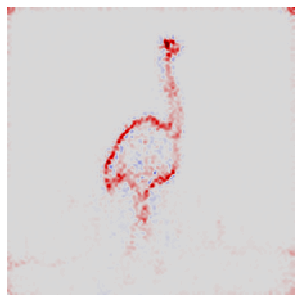

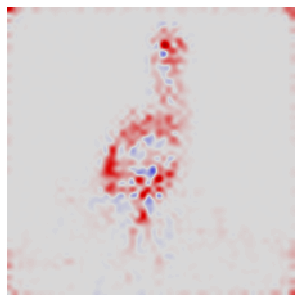

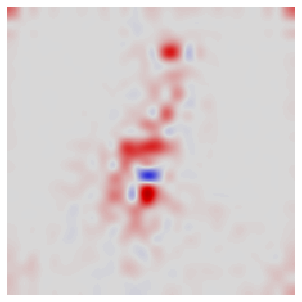

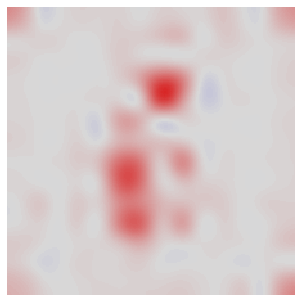

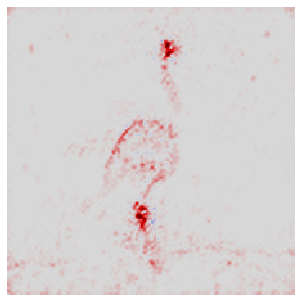

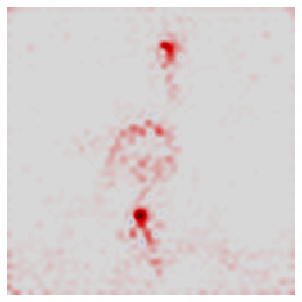

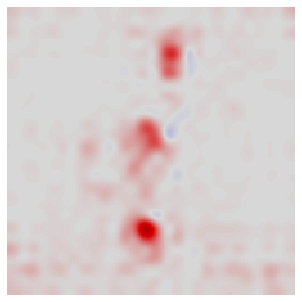

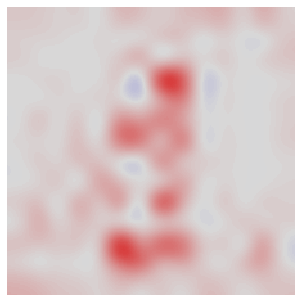

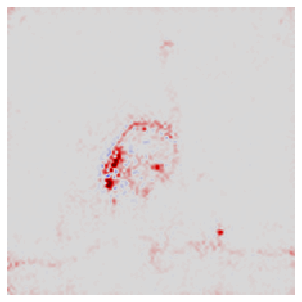

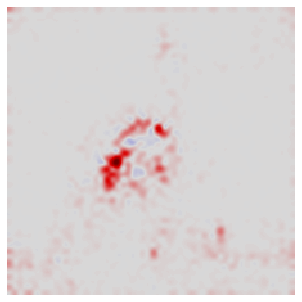

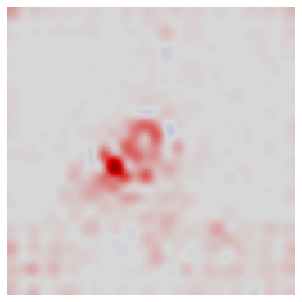

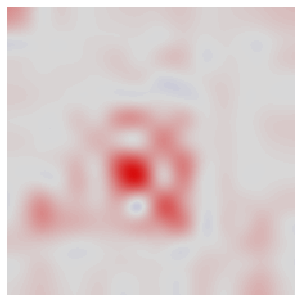

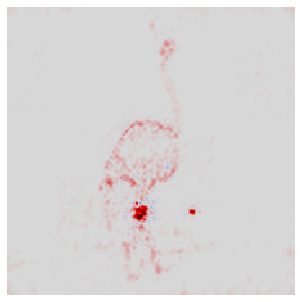

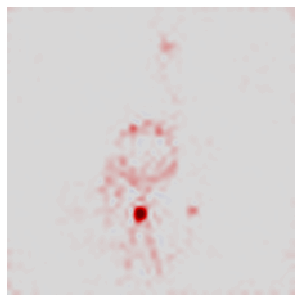

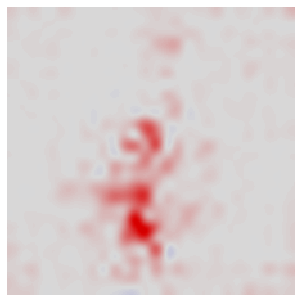

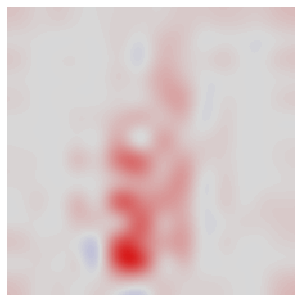

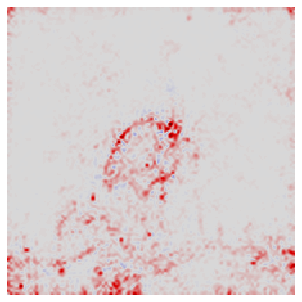

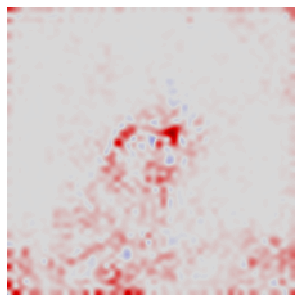

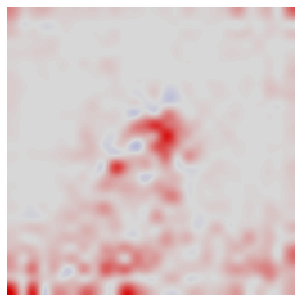

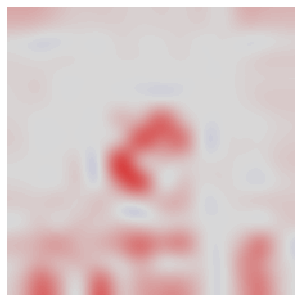

In [ ]:


#from misc_functions import apply_heatmap, get_example_params


class LRP():
    """
        Layer-wise relevance propagation with gamma+epsilon rule
        This code is largely based on the code shared in: https://git.tu-berlin.de/gmontavon/lrp-tutorial
        Some stuff is removed, some stuff is cleaned, and some stuff is re-organized compared to that repository.
    """
    def __init__(self, model):
        self.model = model

    def LRP_forward(self, layer, input_tensor, gamma=None, epsilon=None):
        # This implementation uses both gamma and epsilon rule for all layers
        # The original paper argues that it might be beneficial to sometimes use
        # or not use gamma/epsilon rule depending on the layer location
        # Have a look a the paper and adjust the code according to your needs

        # LRP-Gamma rule
        if gamma is None:
            gamma = lambda value: value + 0.05 * copy.deepcopy(value.data.detach()).clamp(min=0)
        # LRP-Epsilon rule
        if epsilon is None:
            eps = 1e-9
            epsilon = lambda value: value + eps

        # Copy the layer to prevent breaking the graph
        layer = copy.deepcopy(layer)

        # Modify weight and bias with the gamma rule
        try:
            layer.weight = nn.Parameter(gamma(layer.weight))
        except AttributeError:
            pass
            # print('This layer has no weight')
        try:
            layer.bias = nn.Parameter(gamma(layer.bias))
        except AttributeError:
            pass
            # print('This layer has no bias')
        # Forward with gamma + epsilon rule
        return epsilon(layer(input_tensor))

    def LRP_step(self, forward_output, layer, LRP_next_layer):
        # Enable the gradient flow
        forward_output = forward_output.requires_grad_(True)
        # Get LRP forward out based on the LRP rules
        lrp_rule_forward_out = self.LRP_forward(layer, forward_output, None, None)
        # Perform element-wise division
        ele_div = (LRP_next_layer / lrp_rule_forward_out).data
        # Propagate
        (lrp_rule_forward_out * ele_div).sum().backward()
        # Get the visualization
        LRP_this_layer = (forward_output * forward_output.grad).data

        return LRP_this_layer

    def generate(self, input_image, target_class):
        layers_in_model = list(self.model._modules['features']) + list(self.model._modules['classifier'])
        number_of_layers = len(layers_in_model)
        # Needed to know where flattening happens
        features_to_classifier_loc = len(self.model._modules['features'])

        # Forward outputs start with the input image
        forward_output = [input_image]
        # Then we do forward pass with each layer
        for conv_layer in list(self.model._modules['features']):
            forward_output.append(conv_layer.forward(forward_output[-1].detach()))

        # To know the change in the dimensions between features and classifier
        feature_to_class_shape = forward_output[-1].shape
        # Flatten so we can continue doing forward passes at classifier layers
        forward_output[-1] = torch.flatten(forward_output[-1], 1)
        for index, classifier_layer in enumerate(list(self.model._modules['classifier'])):
            forward_output.append(classifier_layer.forward(forward_output[-1].detach()))

        # Target for backprop
        target_class_one_hot = torch.FloatTensor(1, 1000).zero_()
        target_class_one_hot[0][target_class] = 1

        # This is where we accumulate the LRP results
        LRP_per_layer = [None] * number_of_layers + [(forward_output[-1] * target_class_one_hot).data]

        for layer_index in range(1, number_of_layers)[::-1]:
            # This is where features to classifier change happens
            # Have to flatten the lrp of the next layer to match the dimensions
            if layer_index == features_to_classifier_loc-1:
                LRP_per_layer[layer_index+1] = LRP_per_layer[layer_index+1].reshape(feature_to_class_shape)

            if isinstance(layers_in_model[layer_index], (torch.nn.Linear, torch.nn.Conv2d, torch.nn.MaxPool2d)):
                # In the paper implementation, they replace maxpool with avgpool because of certain properties
                # I didn't want to modify the model like the original implementation but
                # feel free to modify this part according to your need(s)
                lrp_this_layer = self.LRP_step(forward_output[layer_index], layers_in_model[layer_index], LRP_per_layer[layer_index+1])
                LRP_per_layer[layer_index] = lrp_this_layer
            else:
                LRP_per_layer[layer_index] = LRP_per_layer[layer_index+1]
        return LRP_per_layer


if __name__ == '__main__':
    # Get params
    pics = [(9, "ostrich"), (421, 'blackSwan'), (450, 'goldfish'), (451, 'eel'), (387, 'goldfinch')]

    for target_example, pic in enumerate(pics):
      actual_class = pic[0]
      label = pic[1]
      (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
          get_example_params(target_example)

      # LRP
      layerwise_relevance = LRP(pretrained_model)

      # Generate visualization(s)
      LRP_per_layer = layerwise_relevance.generate(prep_img, actual_class)

      for layer_num in target_layers:
      # Convert the output nicely, selecting the first layer
        lrp_to_vis = np.array(LRP_per_layer[layer_num][0]).sum(axis=0)
        lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((prep_img.shape[2],
                              prep_img.shape[3]), Image.ANTIALIAS))

        # Apply heatmap and save
        heatmap = apply_heatmap(lrp_to_vis, 4, 4)
        if not os.path.exists('../results/'+str(file_name_to_export)+'_own_class/'):
                os.makedirs('../results/'+str(file_name_to_export)+'_own_class/')

        heatmap.figure.savefig('../results/'+str(file_name_to_export)+'_own_class/LRP_out_layer_'+str(layer_num)+'_'+file_name_to_export +'.png')

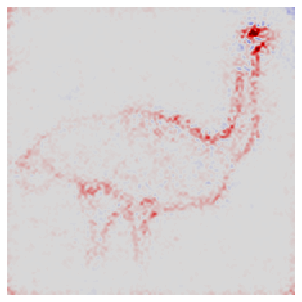

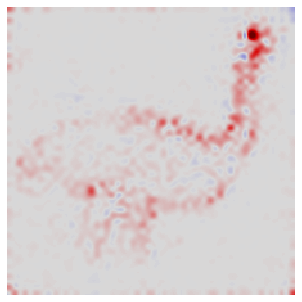

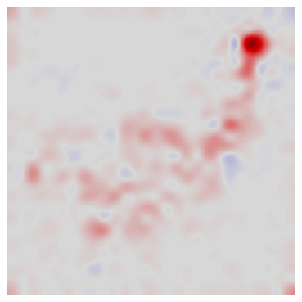

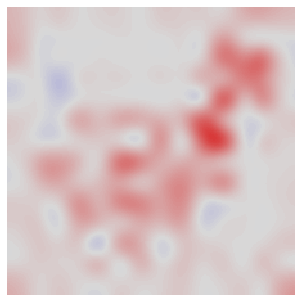

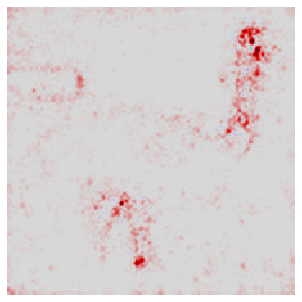

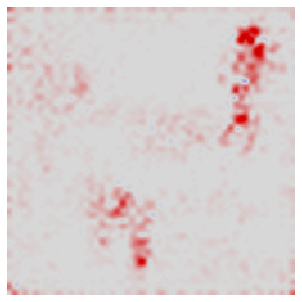

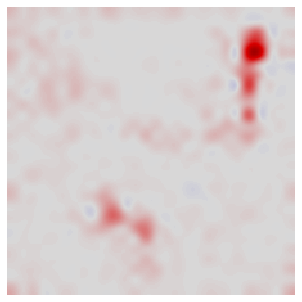

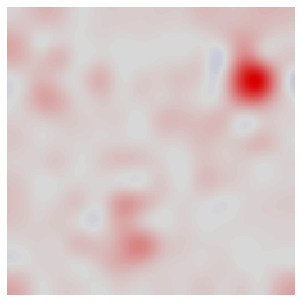

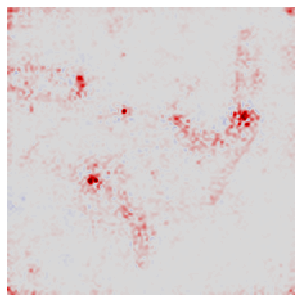

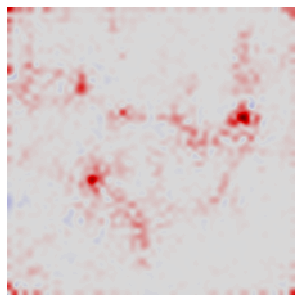

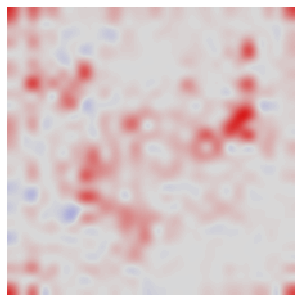

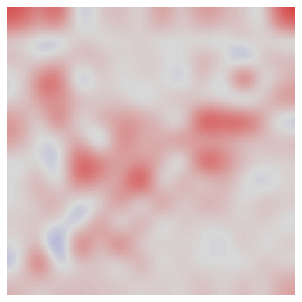

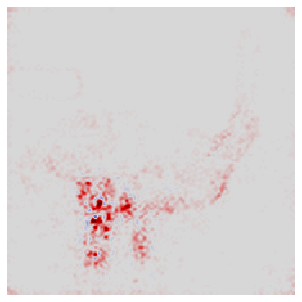

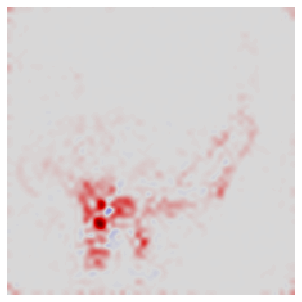

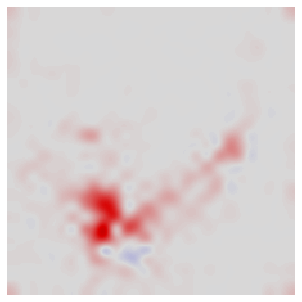

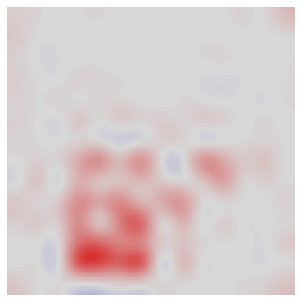

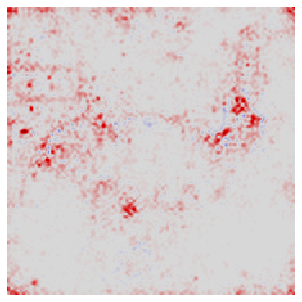

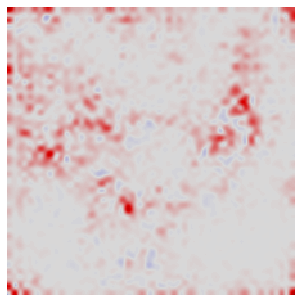

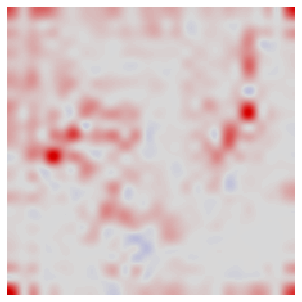

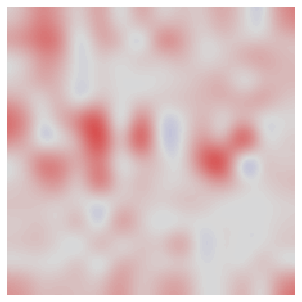

In [ ]:
# Runs layer cam to get activation images for the HEN CLASS ONLY

pics = [(9, "ostrich"), (421, 'blackSwan'), (450, 'goldfish'), (451, 'eel'), (387, 'goldfinch')]

for target_example, pic in enumerate(pics):
    target_class = 9
    label = pic[1]
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)

    # LRP
    layerwise_relevance = LRP(pretrained_model)

    # Generate visualization(s)
    LRP_per_layer = layerwise_relevance.generate(prep_img, target_class)

    for layer_num in target_layers:
    # Convert the output nicely, selecting the first layer
      lrp_to_vis = np.array(LRP_per_layer[layer_num][0]).sum(axis=0)
      lrp_to_vis = np.array(Image.fromarray(lrp_to_vis).resize((prep_img.shape[2],
                            prep_img.shape[3]), Image.ANTIALIAS))

      # Apply heatmap and save
      heatmap = apply_heatmap(lrp_to_vis, 4, 4)
      if not os.path.exists('../results/'+str(file_name_to_export)+'_ostrich_class/'):
              os.makedirs('../results/'+str(file_name_to_export)+'_ostrich_class/')

      heatmap.figure.savefig('../results/'+str(file_name_to_export)+'_ostrich_class/LRP_out_layer_'+str(layer_num)+'_'+file_name_to_export +'.png')